In [1]:
"""
This notebook plots the positions of profile motifs calls relative to the TSS.
We mostly use this to identify the locations of core promoter motifs (Fig. 6B).
"""

'\nThis notebook plots the positions of profile motifs calls relative to the TSS.\nWe mostly use this to identify the locations of core promoter motifs (Fig. 6B).\n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm

from matplotlib.colors import LinearSegmentedColormap

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

# Extract window coordinates & observed PRO-cap tracks from tfmodisco_results.tar.gz
URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR} -C {SCRATCH}")

# Download quantity motif calls
print(f"wget {URL}/profile_annotated_seqlets_full_cleaned.bed.gz -P {SCRATCH}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz -C /Users/adamhe/github/scratch
wget https://zenodo.org/records/10597358/files/profile_annotated_seqlets_full_cleaned.bed.gz -P /Users/adamhe/github/scratch


In [4]:
def epdf(coords, start=-200, end=200):
    a = np.zeros(end - start)
    for coord in tqdm.tqdm(coords):
        if coord in range(start, end):
            a[coord - start] += 1
    return pd.DataFrame(a, index=range(start, end))

In [5]:
# LOAD DATA

# Read in windows around PRO-cap peaks in LCLs
all_bed = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end"],
)
# Load the experimental data:
signals = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/all_tss_windows_procap_mean.csv.gz"),
    header=None,
    index_col=0,
).to_numpy()
signals = signals[:, np.r_[250:750, 1250:1750]]

In [6]:
# Load the motif calls
all_motifs = pd.read_csv(
    Path(SCRATCH, "profile_annotated_seqlets.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "peak_idx", "motif"]
)

# Print motif counts
all_motifs["motif_prefix"] = all_motifs.motif.str.split("-").str[0]
all_motifs.motif_prefix.value_counts()

motif_prefix
CA        95428
TBP       74654
ETS       59373
DPR       48096
YY1       32166
SP/KLF    31933
IRF       29433
TA        23545
NFY       19756
NRF1      19323
Name: count, dtype: int64

In [7]:
# Get TSS coordinates
tss = signals.argmax(axis=1)
is_mn = tss >= 500
tss_df = pd.DataFrame(
    {
        "tss": tss,
        "is_mn": is_mn,
    }
)
# Subtract 500 from tss if is_mn
tss_df["tss"] = tss_df["tss"].apply(lambda x: x - 500 if x >= 500 else x) + 250

In [8]:
motif_positions = []
for i, hit in tqdm.tqdm(all_motifs.iterrows()):
    peak_idx = hit["peak_idx"]
    tss_coord = tss_df["tss"].iloc[peak_idx] + all_bed.iloc[peak_idx]["start"]
    motif_center = (hit["end"] + hit["start"]) // 2
    tss_strand = tss_df["is_mn"].iloc[peak_idx]
    motif_positions.append(
        tss_coord - motif_center if tss_strand else motif_center - tss_coord
    )

motif_positions = np.array(motif_positions)
all_motifs["distance_from_tss"] = motif_positions

433707it [00:20, 20835.28it/s]


In [10]:
xticks = [-200, -100, -50, 0, 50, 100, 200]

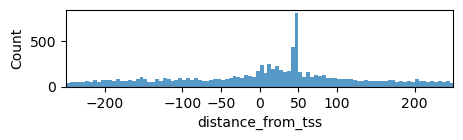

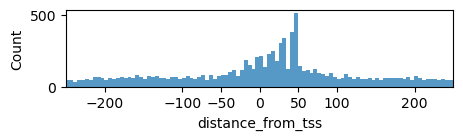

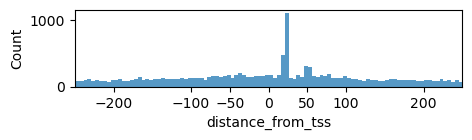

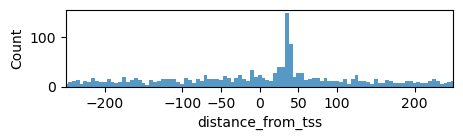

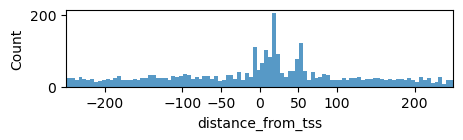

In [18]:
# Generate all motif positioning plots
for i in [0, 1, 2, 4, 8]:
    # Get motif positions
    motif_positions = all_motifs[all_motifs.motif == f"DPR-{i}"]["distance_from_tss"]
    # Set image parameters
    plt.rcParams["figure.figsize"] = 5,1
    fig, (ax) = plt.subplots(nrows = 1, sharex = True)
    # Plot
    #sns.kdeplot(motif_positions, bw_adjust=0.5)
    sns.histplot(motif_positions, binwidth=5, edgecolor='None')
    ax.set_xlim(-250, 250)
    ax.set_xticks(xticks)
    ax.set_yticks([500])
    plt.savefig(
        f"img_profile/DPR-{i}_hist.pdf",
        bbox_inches="tight",
    )

,chrom,start,end,peak_idx,motif,motif_prefix,distance_from_tss
268166,chr1,826781,826786,87,DPR-0,DPR,496
268167,chr1,827396,827401,87,DPR-0,DPR,-119
268168,chr1,827814,827819,94,DPR-0,DPR,156
268169,chr1,1000798,1000803,125,DPR-0,DPR,14
268170,chr1,1058932,1058937,154,DPR-0,DPR,372
...,...,...,...,...,...,...,...
280733,chr9,137745668,137745673,212740,DPR-0,DPR,-60
280734,chr9,137745668,137745673,212744,DPR-0,DPR,-60
280735,chr9,137759985,137759990,212755,DPR-0,DPR,62
280736,chr9,137760409,137760414,212755,DPR-0,DPR,-362


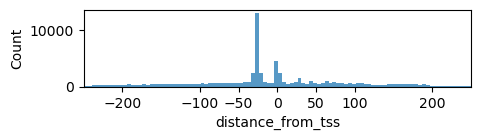

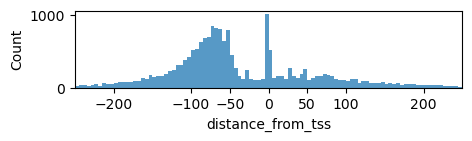

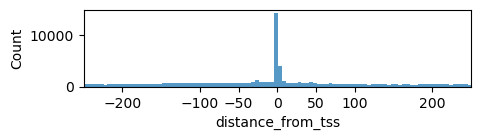

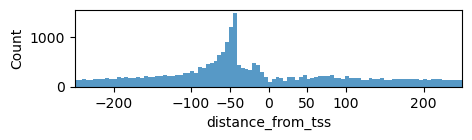

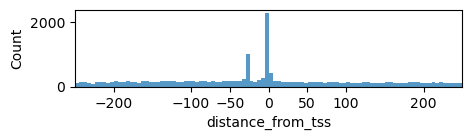

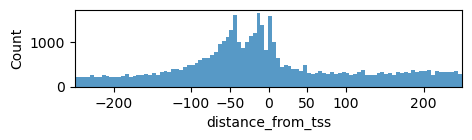

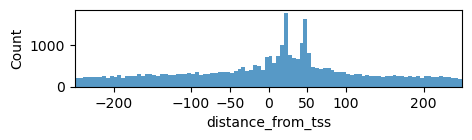

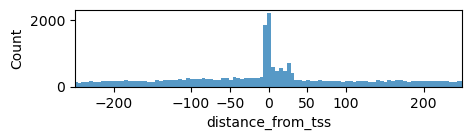

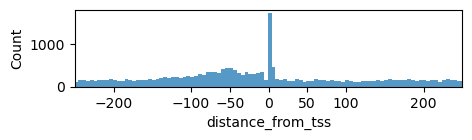

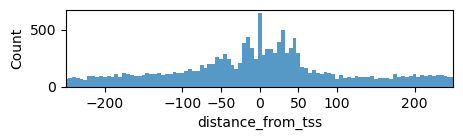

In [207]:
# Generate all motif positioning plots
for motif_name in all_motifs.motif_prefix.unique():
    # Get motif positions
    motif_positions = all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"]
    # Set image parameters
    plt.rcParams["figure.figsize"] = 5,1
    fig, (ax) = plt.subplots(nrows = 1, sharex = True)
    # Plot
    #sns.kdeplot(motif_positions, bw_adjust=0.5)
    sns.histplot(motif_positions, binwidth=5, edgecolor='None')
    ax.set_xlim(-250, 250)
    ax.set_xticks(xticks)
    plt.savefig(
        f"img_profile/{motif_name.replace("/", "")}_hist.pdf",
        bbox_inches="tight",
    )

In [47]:
all_motifs[
    (all_motifs.distance_from_tss <= -45) & (all_motifs.distance_from_tss >= -100)
].motif_prefix.value_counts() / all_motifs.motif_prefix.value_counts()

motif_prefix
CA        0.079453
DPR       0.075391
ETS       0.152965
IRF       0.128563
NFY       0.378872
NRF1      0.105625
SP/KLF    0.215858
TA        0.075048
TBP       0.095775
YY1       0.081017
Name: count, dtype: float64

100%|██████████| 95428/95428 [00:00<00:00, 120218.97it/s]


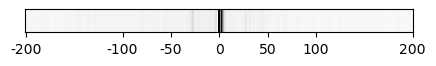

In [208]:
motif_name = "CA"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)
dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Greys", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
#ax.set_xlim(-250, 250)
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 74654/74654 [00:00<00:00, 128021.79it/s]


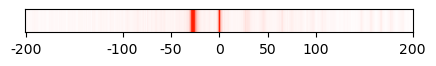

In [209]:
motif_name = "TBP"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#FF1E02"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap=custom_cmap, aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
#ax.set_xlim(-250, 250)
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 48096/48096 [00:00<00:00, 104559.66it/s]


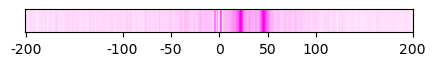

In [210]:
motif_name = "DPR"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#FF02EC"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap=custom_cmap, aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 31933/31933 [00:00<00:00, 124671.03it/s]


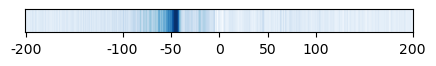

In [211]:
motif_name = "SP/KLF"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 32166/32166 [00:00<00:00, 107654.90it/s]


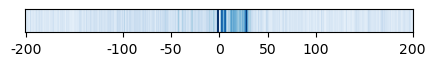

In [212]:
motif_name = "YY1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 19756/19756 [00:00<00:00, 149730.26it/s]


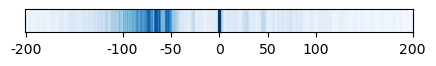

In [213]:
motif_name = "NFY"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 59373/59373 [00:00<00:00, 119489.49it/s]


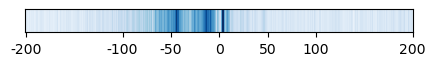

In [214]:
motif_name = "ETS"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 19323/19323 [00:00<00:00, 105755.31it/s]


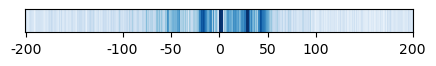

In [201]:
motif_name = "NRF1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 29433/29433 [00:00<00:00, 106370.78it/s]


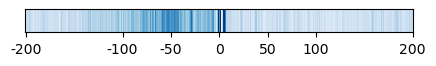

In [216]:
motif_name = "IRF"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)

100%|██████████| 32166/32166 [00:00<00:00, 103750.94it/s]


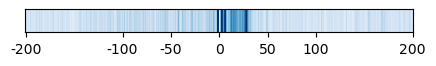

In [199]:
motif_name = "YY1"

plt.rcParams["figure.figsize"] = 5,0.3
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#00EDFF"])

dat = epdf(all_motifs[all_motifs.motif_prefix == motif_name]["distance_from_tss"].to_numpy())
plt.imshow(
    dat.T, cmap="Blues", aspect="auto", vmin=0, vmax=np.percentile(dat, 99.5)
)
plt.yticks([])
plt.xticks(200-np.array(xticks))
ax.set_xticklabels(-np.array(xticks))

plt.savefig(
    f"img_profile/{motif_name.replace("/", "")}_heatmap.pdf",
    bbox_inches="tight",
)